In [1]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Survival Rate (SR) Calculation

\begin{equation}
survival\;rate=\frac{harvested\;shrimp}{seed\;shrimp}
\end{equation}

Data completeness:
- Total seed shrimp can be obtained from "cycle dataset"
- Unfortunately, there's no data for harvested shrimp in "harvest dataset"

On the other hand we have mortality data. Assuming that the mortality data record all number of death shrimps, the equation above can be modified into:

\begin{equation}
survival\;rate=\frac{seed\;shrimp-mortality\;shrimp}{seed\;shrimp}
\end{equation}

In [61]:
df_cycle = pd.read_csv('Data/cycles.csv')
df_cycle = df_cycle[['id', 'pond_id', 'started_at', 'finished_at', 'total_seed']].copy()
# Rename columns & change data type
df_cycle.columns = ['cycle_id', 'pond_id', 'start_date', 'finish_date', 'total_seed_shrimp']
df_cycle.start_date = pd.to_datetime(df_cycle.start_date)
df_cycle.finish_date = pd.to_datetime(df_cycle.finish_date)
# Drop duplicates and null rows
df_cycle = df_cycle.drop_duplicates()
df_cycle = df_cycle.dropna(subset=['cycle_id', 'start_date', 'finish_date', 'total_seed_shrimp'])

df_harvest = pd.read_csv('Data/harvests.csv')
df_harvest = df_harvest[['cycle_id', 'harvested_at', 'status']].copy()
# Rename columns & change data type
df_harvest.columns = ['cycle_id', 'harvest_date', 'harvest_status']
df_harvest.harvest_date = pd.to_datetime(df_harvest.harvest_date)
df_harvest.cycle_id = df_harvest.cycle_id.astype(int)
# Drop duplicates and null rows
df_harvest = df_harvest.drop_duplicates()
df_harvest = df_harvest.dropna(subset=['cycle_id', 'harvest_date', 'harvest_status'])

df_mortalities = pd.read_csv('Data/mortalities.csv')
df_mortalities = df_mortalities[['cycle_id', 'recorded_at', 'quantity']].copy()
# Rename columns & change data type
df_mortalities.columns = ['cycle_id', 'record_date', 'total_mortality_shrimp']
df_mortalities.record_date = pd.to_datetime(df_mortalities.record_date)
# Drop duplicates and null rows
df_mortalities = df_mortalities.drop_duplicates()
df_mortalities = df_mortalities.dropna(subset=['cycle_id', 'record_date', 'total_mortality_shrimp'])

In [62]:
# Count harvest
df_count_harvest = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_harvest[['cycle_id', 'harvest_date']], 
                                                                              how='inner', on=['cycle_id'])
df_count_harvest = df_count_harvest[(df_count_harvest.start_date<=df_count_harvest.harvest_date)&(df_count_harvest.finish_date>=df_count_harvest.harvest_date)]
df_count_harvest = df_count_harvest.drop_duplicates()
df_count_harvest = df_count_harvest.groupby(['cycle_id', 'start_date', 'finish_date']).count().reset_index()
df_count_harvest.columns = ['cycle_id', 'start_date', 'finish_date', 'harvest_times']
# Join cycle & harvest
df_cycle_harvest = df_cycle.merge(df_harvest[df_harvest.harvest_status=='Full'], 
                                  how='inner', left_on=['cycle_id', 'finish_date'], right_on=['cycle_id', 'harvest_date'])
df_cycle_harvest = df_cycle_harvest.merge(df_count_harvest, how='left', on=['cycle_id', 'start_date', 'finish_date'])
df_cycle_harvest = df_cycle_harvest.drop(columns='harvest_date')
df_cycle_harvest

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1
1,22118,37102,2023-04-26,2023-06-23,40000,Full,2
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1
...,...,...,...,...,...,...,...
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3
2135,19131,34712,2022-10-25,2023-01-21,300000,Full,1
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2
2137,15868,32398,2022-04-28,2022-06-21,150000,Full,1


In [70]:
# Count Mortality
df_count_mortality = df_cycle[['cycle_id', 'start_date', 'finish_date']].merge(df_mortalities, 
                                                                               how='inner', on=['cycle_id'])
df_count_mortality = df_count_mortality[(df_count_mortality.start_date<=df_count_mortality.record_date)&(df_count_mortality.finish_date>=df_count_mortality.record_date)]
df_count_mortality = df_count_mortality.drop_duplicates()
df_count_mortality = df_count_mortality.drop(columns='record_date').groupby(['cycle_id', 'start_date', 'finish_date']).sum().reset_index()
# Join cycle & harvest & mortality
df_cycle_harvest_mortality = df_cycle_harvest.merge(df_count_mortality, how='left', on=['cycle_id', 'start_date', 'finish_date'])
df_cycle_harvest_mortality

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times,total_mortality_shrimp
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1,33957.0
1,22118,37102,2023-04-26,2023-06-23,40000,Full,2,NaN
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2,23355.0
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2,11766.0
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1,54.0
...,...,...,...,...,...,...,...,...
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3,24362.0
2135,19131,34712,2022-10-25,2023-01-21,300000,Full,1,NaN
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2,1800.0
2137,15868,32398,2022-04-28,2022-06-21,150000,Full,1,4981.0


In [71]:
df_cycle_harvest_mortality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cycle_id                2139 non-null   int64         
 1   pond_id                 2139 non-null   int64         
 2   start_date              2139 non-null   datetime64[ns]
 3   finish_date             2139 non-null   datetime64[ns]
 4   total_seed_shrimp       2139 non-null   int64         
 5   harvest_status          2139 non-null   object        
 6   harvest_times           2139 non-null   int64         
 7   total_mortality_shrimp  744 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 133.8+ KB


In [72]:
# Drop null rows - Only calculate SR for shrimp cycle that have mortality record & harvest status = Full (finish)
df_cycle_harvest_mortality = df_cycle_harvest_mortality.dropna(subset=['total_mortality_shrimp'])
# Validate data: total_mortality_shrimp must be less than or equal to total_seed_shrimp
df_cycle_harvest_mortality = df_cycle_harvest_mortality[df_cycle_harvest_mortality.total_seed_shrimp >= df_cycle_harvest_mortality.total_mortality_shrimp]
df_cycle_harvest_mortality

,cycle_id,pond_id,start_date,finish_date,total_seed_shrimp,harvest_status,harvest_times,total_mortality_shrimp
0,18876,36294,2022-10-14,2023-01-29,331920,Full,1,33957.0
2,24088,39154,2023-08-01,2023-10-18,357570,Full,2,23355.0
3,17743,20914,2022-07-19,2022-09-29,168275,Full,2,11766.0
4,17125,34187,2022-07-07,2022-09-20,188000,Full,1,54.0
6,26058,44147,2023-10-02,2024-03-03,148007,Full,7,19897.0
...,...,...,...,...,...,...,...,...
2127,21687,38743,2023-04-06,2023-06-10,228344,Full,1,31080.0
2133,25362,43578,2023-10-16,2024-01-31,221000,Full,3,6424.0
2134,24771,42826,2023-08-10,2023-11-13,226284,Full,3,24362.0
2136,27552,45697,2023-11-05,2024-02-13,100000,Full,2,1800.0


In [74]:
# Calculate SR
df_cycle_harvest_mortality['survival_rate'] = 1 - df_cycle_harvest_mortality['total_mortality_shrimp'] / df_cycle_harvest_mortality['total_seed_shrimp']
# Save the final data calculation
df_cycle_harvest_mortality.to_csv('SR_calculation.csv', index=False)

In [75]:
df_cycle_harvest_mortality.survival_rate.describe()

count    738.000000
mean       0.924317
std        0.111871
min        0.034534
25%        0.910319
50%        0.967140
75%        0.990451
max        0.999997
Name: survival_rate, dtype: float64

<Axes: xlabel='survival_rate', ylabel='Count'>

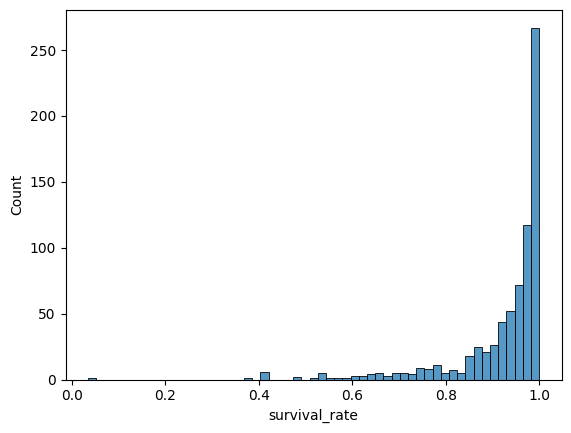

In [76]:
sns.histplot(df_cycle_harvest_mortality, x="survival_rate")

Summary
- The median survival rate is 96.7%